In [0]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class MNIST_IncrementalDataset(torchvision.datasets.MNIST):
    def __init__(self, 
                 source='./mnist_data', 
                 train=True,
                 transform=None,
                 download=False,
                 classes=range(10)):
        
        super(MNIST_IncrementalDataset, self).__init__(source, 
                                                       train, 
                                                       transform, 
                                                       download=True)
        self.train = train

        if train:
            train_data = []
            train_labels = []
            for i in range(len(self.train_data)):
                if self.train_labels[i] in classes:
                    train_data.append(self.train_data[i].type(dtype=torch.float32))
                    train_labels.append(self.train_labels[i])
            
            self.TrainData = train_data
            self.TrainLabels = train_labels

        else:
            test_data = []
            test_labels = []
            for i in range(len(self.test_data)):
                if self.test_labels[i] in classes:
                    test_data.append(self.test_data[i].type(dtype=torch.float32))
                    test_labels.append(self.test_labels[i])
            
            self.TestData = test_data
            self.TestLabels = test_labels

    def __getitem__(self, index):
        if self.train:
            return self.TrainData[index], self.TrainLabels[index]
        else:
            return self.TestData[index], self.TestLabels[index]

    def __len__(self):
        if self.train:
            return len(self.TrainLabels)
        else:
            return len(self.TestLabels)

In [0]:
# Hyperparameters
batch_size = num_noise = 64

# standardization code
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), ])
TrainDataLoaders = []
TestDataLoaders  = []

for i in range(5):
    # MNIST dataset
    TrainDataSet = MNIST_IncrementalDataset(source='data/', 
                                            train=True, 
                                            transform=transform, 
                                            download=True, 
                                            classes=range(i * 2, (i+1) * 2))
    TestDataSet = MNIST_IncrementalDataset(source='data/', 
                                           train=False, 
                                           transform=transform, 
                                           download=True, 
                                           classes=range(i * 2, (i+1) * 2))

    TrainDataLoaders.append(torch.utils.data.DataLoader(TrainDataSet, 
                                                        batch_size=batch_size, 
                                                        shuffle=True))
    TestDataLoaders.append(torch.utils.data.DataLoader(TestDataSet, 
                                                       batch_size=batch_size, 
                                                       shuffle=False))


Extracting data/MNIST_IncrementalDataset/raw/train-images-idx3-ubyte.gz to data/MNIST_IncrementalDataset/raw



Extracting data/MNIST_IncrementalDataset/raw/train-labels-idx1-ubyte.gz to data/MNIST_IncrementalDataset/raw



Extracting data/MNIST_IncrementalDataset/raw/t10k-images-idx3-ubyte.gz to data/MNIST_IncrementalDataset/raw



Extracting data/MNIST_IncrementalDataset/raw/t10k-labels-idx1-ubyte.gz to data/MNIST_IncrementalDataset/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


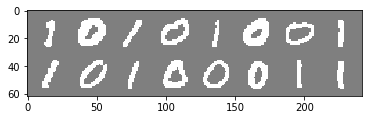

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


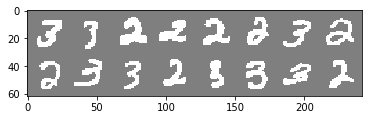

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


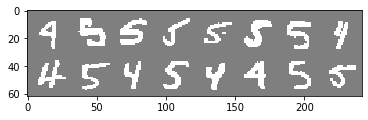

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


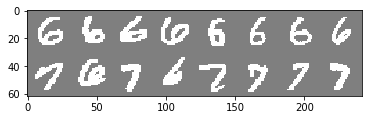

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


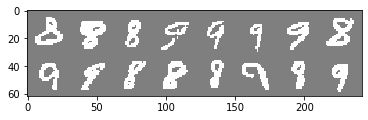

In [0]:
def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = torchvision.utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    plt.imshow(npimg)
    plt.show()
    
for i in range(5):
    example_mini_batch_img, example_mini_batch_label  = next(iter(TrainDataLoaders[i]))
    imshow_grid(example_mini_batch_img[0:16,:,:].view(16, -1, 28, 28))

In [0]:
class Generator(torch.nn.Module):
    """
    Generator Class for GAN
    """
    def __init__(self):
        super(Generator, self).__init__()
        conv2d_1 = torch.nn.ConvTranspose2d(in_channels=num_noise,
                                   out_channels=28*8, 
                                   kernel_size=7, 
                                   stride=1,
                                   padding=0,
                                   bias=False)
        conv2d_2 = torch.nn.ConvTranspose2d(in_channels=28*8, 
                                   out_channels=28*4, 
                                   kernel_size=4, 
                                   stride=2,
                                   padding=1,
                                   bias=False)
        conv2d_3 = torch.nn.ConvTranspose2d(in_channels=28*4, 
                                   out_channels=1, 
                                   kernel_size=4, 
                                   stride=2,
                                   padding=1,
                                   bias=False)

        self.network = torch.nn.Sequential(
            conv2d_1,
            torch.nn.BatchNorm2d(num_features = 28*8),
            torch.nn.ReLU(inplace=True),
            conv2d_2,
            torch.nn.BatchNorm2d(num_features = 28*4),
            torch.nn.ReLU(inplace=True),
            conv2d_3,
            torch.nn.Tanh()
        )

        if torch.cuda.is_available():
            self.network = self.network.cuda()

    def forward(self, x):
        return self.network(x.view(-1, num_noise, 1, 1))

In [0]:
class Discriminator(torch.nn.Module):
    """
    Discriminator Class for GAN
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        conv2d_1 = torch.nn.Conv2d(in_channels=1, 
                                   out_channels=28*4, 
                                   kernel_size=4, 
                                   stride=2,
                                   padding=1,
                                   bias=False)
        conv2d_2 = torch.nn.Conv2d(in_channels=28*4, 
                                   out_channels=28*8, 
                                   kernel_size=4, 
                                   stride=2,
                                   padding=1,
                                   bias=False)
        conv2d_3 = torch.nn.Conv2d(in_channels=28*8, 
                                   out_channels=1, 
                                   kernel_size=7, 
                                   stride=1,
                                   padding=0,
                                   bias=False)

        self.network = torch.nn.Sequential(
            conv2d_1,
            torch.nn.BatchNorm2d(num_features=28*4),
            torch.nn.LeakyReLU(inplace=True),
            conv2d_2,
            torch.nn.BatchNorm2d(num_features=28*8),
            torch.nn.LeakyReLU(inplace=True),
            conv2d_3,
            torch.nn.Sigmoid()
        )

        if torch.cuda.is_available():
            self.network = self.network.cuda()

    def forward(self, x):
        return self.network(x).view(-1, 1)

In [0]:
class Solver(torch.nn.Module):
    """
    Solver Class for Deep Generative Replay
    """
    def __init__(self, T_n):
        super(Solver, self).__init__()
        fc1 = torch.nn.Linear(28*28, 100)
        fc2 = torch.nn.Linear(100, 100)
        fc3 = torch.nn.Linear(100, T_n * 2)
        self.network = torch.nn.Sequential(
            fc1,
            torch.nn.ReLU(),
            fc2,
            torch.nn.ReLU(),
            fc3
        )

        if torch.cuda.is_available():
            self.network = self.network.cuda()

    def forward(self, x):
        return self.network(x.view(x.shape[0], 28*28))

In [0]:
def sample_noise(batch_size, N_noise):
    """
    Returns 
    """
    if torch.cuda.is_available():
        return torch.randn(batch_size, N_noise).cuda()
    else:
        return torch.randn(batch_size, N_noise)

In [0]:
def train(cur_task, gen, disc, solver, pre_gen, pre_solver, ratio, epochs):
    assert (ratio >=0 or ratio <= 1)
    bceloss = torch.nn.BCELoss()
    celoss = torch.nn.CrossEntropyLoss()

    gen_optim = torch.optim.Adam(gen.parameters(), lr=0.0002)
    disc_optim = torch.optim.Adam(disc.parameters(), lr=0.0002)
    solver_optim = torch.optim.Adam(solver.parameters(), lr=0.0001)
    train_dataloader = TrainDataLoaders[cur_task]
    
    # GAN Training
    for epoch in range(epochs):
        for image, label in train_dataloader:
            if torch.cuda.is_available():
                image = image.cuda()
                label = label.cuda()

            if pre_gen is not None:
                # append generated image & label from previous scholar
                gen_image = pre_gen(sample_noise(batch_size, num_noise))
                gen_label = pre_solver(gen_image).max(dim=1)[1]

                image = torch.cat((image, gen_image))
                label = torch.cat((label, gen_label))

            ### Discriminator Training
            disc_optim.zero_grad()
            p_real = disc(image.view(image.shape[0], -1 , 28, 28))
            p_fake = disc(gen(sample_noise(image.shape[0], num_noise)))

            ones = torch.ones_like(p_real)
            zeros = torch.zeros_like(p_real)
            if torch.cuda.is_available():
                ones = ones.cuda()
                zeros = zeros.cuda()

            loss_d = bceloss(p_real, ones) + bceloss(p_fake, zeros)

            loss_d.backward()
            disc_optim.step()

            ### Generator Training
            gen_optim.zero_grad()
            p_fake = disc(gen(sample_noise(batch_size, num_noise)))

            ones = torch.ones_like(p_fake)
            if torch.cuda.is_available():
                ones = ones.cuda()

            loss_g = bceloss(p_fake, ones)
            loss_g.backward()

            gen_optim.step()

        if epoch % 10 == 9:
            p_real, p_fake = gan_evaluate(cur_task, gen, disc)
            gen_image = gen(sample_noise(batch_size, num_noise))
            print("(Epoch {}/{}) p_real: {} | p_fake: {}\n".format(epoch, epochs, p_real, p_fake))
            imshow_grid(gen_image)
    
    # train solver
    for image, label in train_dataloader:
        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()

        output = solver(image)
        loss = celoss(output, label) * ratio

        if pre_solver is not None:
            noise = sample_noise(batch_size, num_noise)
            g_image = pre_gen(noise)
            g_label = pre_solver(g_image).max(dim=1)[1]
            g_output = solver(g_image)
            loss += celoss(g_output, g_label) * (1 - ratio)

        loss.backward()
        solver_optim.step()

In [0]:
def gan_evaluate(cur_task, gen, disc):
    p_real = p_fake = 0.0
    test_dataloaders = TestDataLoaders[:cur_task+1]
    
    gen.eval()
    disc.eval()
        
    for testloader in test_dataloaders:
        for image, _ in testloader:
            if torch.cuda.is_available():
                image = image.cuda()

            with torch.autograd.no_grad():
                p_real += (torch.sum(disc(image.view(image.shape[0], -1 , 28, 28))).item())/10000.
                p_fake += (torch.sum(disc(gen(sample_noise(batch_size, num_noise)))).item())/10000.

            
    return p_real, p_fake

In [0]:
def solver_evaluate(cur_task, gen, solver, ratio):
    gen.eval()
    solver.eval()

    solver_loss = 0.0
    celoss = torch.nn.CrossEntropyLoss()
    test_dataloader = TestDataLoaders[:cur_task+1]

    for i, data in enumerate(test_dataloader):
        for image, label in data:
            if torch.cuda.is_available():
                image = image.cuda()
                label = label.cuda()

            with torch.autograd.no_grad():
                output = solver(image)
                if i == cur_task:
                    solver_loss += celoss(output, label) * ratio
                
                else:
                    solver_loss += celoss(output, label) * (1 - ratio)


    return solver_loss

(Epoch 9/100) p_real: 0.2100780282020569	 p_fake: 7.928988095372913e-05



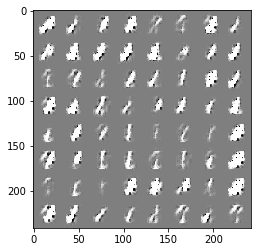

(Epoch 19/100) p_real: 0.21149777793884267	 p_fake: 1.1440426387707702e-07



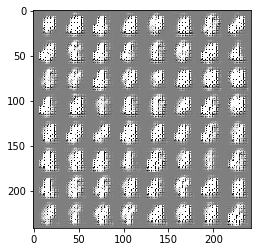

(Epoch 29/100) p_real: 0.21149860801696768	 p_fake: 3.929831018467666e-08



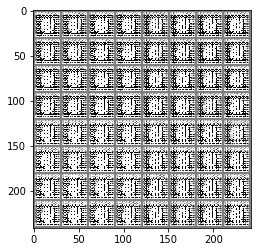

(Epoch 39/100) p_real: 0.21149931602478017	 p_fake: 1.1538940998434557e-08



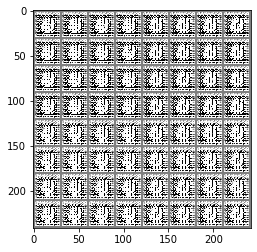

In [0]:
ratio = 0.5
epochs = 100
gan_p_real_list = []
gan_p_fake_list = []
solver_loss_list = []
pre_gen = None
pre_solver = None

for i in range(5):
    if i > 0:
        pre_gen = gen
        pre_solver = solver

    gen = Generator()
    disc = Discriminator()
    solver = Solver(i+1)
    train(i, gen, disc, solver, pre_gen, pre_solver, ratio, epochs)
    solver_loss = solver_evaluate(i, gen, solver, ratio)
    
    solver_loss_list.append(solver_loss)
    print("Task {} solver's loss: {}\n".format(i+1, solver_loss))
    images = gen(sample_noise(batch_size, num_noise))
    imshow_grid(images)